# Regression with a modular simulation model
The semi empirical rudder is not part of the regression, but needs to be subtracted from the left hand side.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/08/23 16:35:13] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=470383;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=152182;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/08/23 16:35:25] INFO     Kedro project phd                                                      ]8;id=521873;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=568261;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=24668;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=50317;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=457953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=9596;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=281413;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=803325;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=392305;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=132500;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=46099;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902123;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=434502;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=89972;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=10956;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=768562;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=5044;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=643732;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
#fx_eq = fx_eq.subs(X_D,X_D_)
#fy_eq = fy_eq.subs(Y_D,Y_D_)
#mz_eq = mz_eq.subs(N_D,N_D_)

f_X_H = sp.Function('X_H')(u,v,r,delta)
f_Y_H = sp.Function('Y_H')(u,v,r,delta)
f_N_H = sp.Function('N_H')(u,v,r,delta)

f_X_R = sp.Function('X_R')(u,v,r,delta,thrust)
f_Y_R = sp.Function('Y_R')(u,v,r,delta,thrust)
f_N_R = sp.Function('N_R')(u,v,r,delta,thrust)

f_X_P = sp.Function('X_P')(u,v,r,rev)

eq_X_force = fx_eq.subs(X_D, f_X_H + f_X_R)
eq_Y_force = fy_eq.subs(Y_D, f_Y_H + f_Y_R)
eq_N_force = mz_eq.subs(N_D, f_N_H + f_N_R)

X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_H(u, v, r, delta) + X_R(u, v, r, delta, thrust))

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_H(u, v, r, delta) + Y_R(u, v, r, delta, thrust))

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v} + N_H(u, v, r, delta) + N_R(u, v, r, delta, thrust))

In [6]:
model_old= model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [417]:
parameters = dict(model_old.parameters)
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}
parameters.update(params)
g_=9.81
parameters['g'] = g_

rudder_particulars = {
'x_R'   : ship_data['x_r'],
'y_R'   : 0,
'z_R'   : 0,
'A_R'   : 70/(ship_data['scale_factor']**2),
'b_R'   : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f'   :ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}

rudder_parameters = {
"C_L_tune" : 1.0,
#"delta_lim": np.deg2rad(40),
"delta_lim": 2*0.6981317007977318,
"kappa": 0.5, # (Small value means much flow straightening)
"nu":1.18849E-06,
}
parameters.update(rudder_parameters)

ship_parameters = ship_data.copy()
ship_parameters.update(rudder_particulars)
ship_parameters.update(prop_data)


In [418]:
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=parameters, 
                               control_keys=['delta','thrust'], do_create_jacobian=False)

In [419]:
model_old_modular = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=parameters, 
                               control_keys=['delta','thrust'], do_create_jacobian=False)

## Add semi-empirical rudder

In [420]:
rudders = SemiempiricalRudderSystem(ship=model, create_jacobians=False)
model.subsystems['rudders'] = rudders

## Add hull

In [421]:
eq_X_H = model_old.X_qs_eq.subs([
(X_D, X_H,),
#(thrust,0),
(delta,0),
])

eq_Y_H = model_old.Y_qs_eq.subs([
(Y_D, Y_H,),
(delta,0),
(thrust,0),
])

eq_N_H = model_old.N_qs_eq.subs([
(N_D, N_H,),
(delta,0),
(thrust,0),

])

display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)


Eq(X_H, X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{r}*r + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_H, N_{r}*r + N_{ur}*r*u + N_{u}*u + N_{v}*v)

## Add polynomial rudder for the old modular model

In [422]:
eq_X_R_old = sp.Eq(f_X_R,model_old.X_qs_eq.rhs.subs(eq_X_H.rhs,0))
eq_Y_R_old = sp.Eq(f_Y_R,model_old.Y_qs_eq.rhs.subs(eq_Y_H.rhs,0))
eq_N_R_old = sp.Eq(f_N_R,model_old.N_qs_eq.rhs.subs(eq_N_H.rhs,0))
display(eq_X_R_old)
display(eq_Y_R_old)
display(eq_N_R_old)

Eq(X_R(u, v, r, delta, thrust), X_{deltadelta}*delta**2)

Eq(Y_R(u, v, r, delta, thrust), Y_{delta}*delta + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{vvdelta}*delta*v**2)

Eq(N_R(u, v, r, delta, thrust), N_{delta}*delta + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{vvdelta}*delta*v**2)

In [423]:
equations_rudders_old_modular = [eq_X_R_old, eq_Y_R_old, eq_N_R_old]
rudders_old_modular = PrimeEquationSubSystem(ship=model_old_modular, equations=equations_rudders_old_modular, create_jacobians=False)
model_old_modular.subsystems['rudders'] = rudders_old_modular

In [424]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull, create_jacobians=False)
model.subsystems['hull'] = hull

hull_old_modular = PrimeEquationSubSystem(ship=model_old_modular, equations=equations_hull, create_jacobians=False)
model_old_modular.subsystems['hull'] = hull_old_modular

## Regression

In [425]:
data = time_series_smooth['wpcc.updated.joined.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [426]:
df_forces = model.forces_from_motions(data=data)
data['fx'] = df_forces['fx']
data['fy'] = df_forces['fy']
data['mz'] = df_forces['mz']

<Axes: >

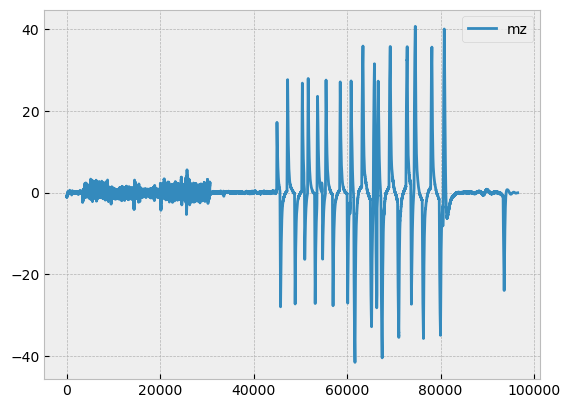

In [427]:
data.plot(y='mz')

In [428]:
eq_f_X_H = sp.Eq(f_X_H, sp.solve(model.X_eq, f_X_H)[0])
eq_f_Y_H = sp.Eq(f_Y_H, sp.solve(model.Y_eq, f_Y_H)[0])
eq_f_N_H = sp.Eq(f_N_H, sp.solve(model.N_eq, f_N_H)[0])


In [429]:
u_prime, v_prime = sp.symbols("u' v'")
subs = [
(u,u_prime),
(v,v_prime),
]

#eq_f_X_H = eq_f_X_H.subs(subs)
#eq_f_Y_H = eq_f_Y_H.subs(subs)
#eq_f_N_H = eq_f_N_H.subs(subs)

#subs_prime = [
#    (f_X_R,f_X_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#    (f_Y_R,f_Y_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#    (f_N_R,f_N_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**3)),
#    (f_X_P,f_X_P/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#]
#
#eq_f_X_H = eq_f_X_H.subs(subs_prime)
#eq_f_Y_H = eq_f_Y_H.subs(subs_prime)
#eq_f_N_H = eq_f_N_H.subs(subs_prime)

display(eq_f_X_H)
display(eq_f_Y_H)
display(eq_f_N_H)


Eq(X_H(u, v, r, delta), -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v - X_R(u, v, r, delta, thrust))

Eq(Y_H(u, v, r, delta), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u - Y_R(u, v, r, delta, thrust))

Eq(N_H(u, v, r, delta), I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + \dot{v}*m*x_G + m*r*u*x_G - N_R(u, v, r, delta, thrust))

In [430]:
states_str = [str(state.subs(subs_simpler)).replace('_','') for state in model.states]

In [431]:
calculation = model.calculate_forces(states_dict=data[states_str], control=data[model.control_keys])
calculation_ = {
'X_R': calculation['X_R'],
'Y_R': calculation['Y_R'],
'N_R': calculation['N_R'],
}


calculation_prime = model.prime_system.prime(calculation_, U=data['U'])


In [432]:
data_prime = model.prime_system.prime(data[states_str+['u1d','v1d','r1d','fx','fy','mz','thrust']], U=data['U'])
data_prime['X_R'] = calculation_prime['X_R']
data_prime['Y_R'] = calculation_prime['Y_R']
data_prime['N_R'] = calculation_prime['N_R']


In [433]:
eqs = [eq_f_X_H, eq_f_Y_H, eq_f_N_H]
lambdas = {eq.lhs.name:lambdify(eq.rhs.subs(subs_simpler), substitute_functions=True) for eq in eqs} 

In [434]:
for key, lambda_ in lambdas.items():

    data_prime[key] = run(lambda_, 
        inputs=data_prime, 
        **calculation_prime, 
        **model.ship_parameters_prime, 
        **model.parameters)

In [435]:
data_prime[['X_H','Y_H','N_H']]

,X_H,Y_H,N_H
0,0.000057,-0.000077,-0.000025
1,0.000066,-0.000077,-0.000025
2,0.000082,-0.000077,-0.000025
3,0.000092,-0.000076,-0.000025
4,0.000093,-0.000076,-0.000025
...,...,...,...
96495,0.000415,0.000125,0.000004
96496,0.000429,0.000125,0.000004
96497,0.000436,0.000125,0.000004
96498,0.000434,0.000125,0.000004


In [436]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2}

In [437]:
hull.equations['X_H']

Eq(X_H, X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [438]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2}

In [439]:
exclude_parameters = {
'Xthrust' : model_old.parameters['Xthrust']
}

In [440]:
eq = hull.equations['X_H']

eq_to_matrix_X_H = DiffEqToMatrix(eq, label=X_H, base_features=[u,v,r,thrust], exclude_parameters=exclude_parameters)

eq = hull.equations['Y_H'].subs(thrust,0)
eq_to_matrix_Y_H = DiffEqToMatrix(eq, label=Y_H, base_features=[u,v,r])

eq = hull.equations['N_H'].subs(thrust,0)
eq_to_matrix_N_H = DiffEqToMatrix(eq, label=N_H, base_features=[u,v,r])


In [441]:
new_parameters = {key:value for key,value in parameters.items() if 'dot' in key}
new_parameters['Xthrust'] = model_old.parameters['Xthrust']

In [442]:
models = {}
for eq_to_matrix in [eq_to_matrix_X_H, eq_to_matrix_Y_H, eq_to_matrix_N_H]:
    key = eq_to_matrix.acceleration_equation.lhs.name
    X,y = eq_to_matrix.calculate_features_and_label(data=data_prime, y=data_prime[key])
    ols = sm.OLS(y,X)
    models[key] = ols_fit = ols.fit()
    new_parameters.update(ols_fit.params)

In [443]:
for key,fit in models.items():
    display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    X_H   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          2.563e+06
Date:                Thu, 08 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:42:05   Log-Likelihood:                      7.6704e+05
No. Observations:               96500   AIC:                                 -1.534e+06
Df Residuals:                   96496   BIC:                                 -1.534e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xvr           -0.0095   6.07e-05   -155.740      0.000      -0.010      -0.009
Xuu            0.0110      0.000     82.566      0.000       0.011       0.011
Xu            -0.0118      0.000    -88.906      0.000      -0.012      -0.012
Xrr           -0.0041   1.75e-05   -236.284      0.000      -0.004      -0.004
==============================================================================
Omnibus:                    16167.420   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           299413.441
Skew:                          -0.228   Prob(JB):                         0.00
Kurtosis:                      11.617   Cond. No.                         992.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Y_H   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          3.093e+06
Date:                Thu, 08 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:42:05   Log-Likelihood:                      6.3958e+05
No. Observations:               96500   AIC:                                 -1.279e+06
Df Residuals:                   96496   BIC:                                 -1.279e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yr             0.0722      0.000    505.487      0.000       0.072       0.072
Yur           -0.0732      0.000   -517.877      0.000      -0.074      -0.073
Yu         -2.074e-05   1.11e-06    -18.668      0.000   -2.29e-05   -1.86e-05
Yv            -0.0159   2.81e-05   -566.978      0.000      -0.016      -0.016
==============================================================================
Omnibus:                    69128.784   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2033865.410
Skew:                          -3.110   Prob(JB):                         0.00
Kurtosis:                      24.613   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    N_H   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.016e+06
Date:                Thu, 08 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:42:05   Log-Likelihood:                      7.1620e+05
No. Observations:               96500   AIC:                                 -1.432e+06
Df Residuals:                   96496   BIC:                                 -1.432e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nr            -0.0411   6.45e-05   -636.850      0.000      -0.041      -0.041
Nur            0.0391   6.39e-05    612.118      0.000       0.039       0.039
Nu         -6.477e-06   5.02e-07    -12.895      0.000   -7.46e-06   -5.49e-06
Nv            -0.0022   1.27e-05   -171.390      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    91012.746   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4412119.068
Skew:                           4.588   Prob(JB):                         0.00
Kurtosis:                      34.829   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

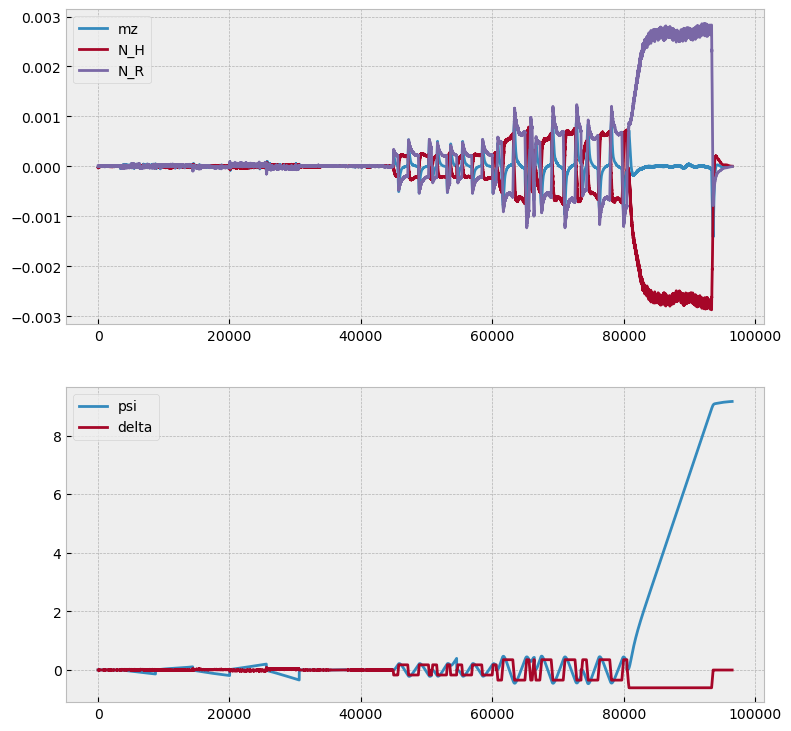

In [444]:
fig,axes=plt.subplots(nrows=2)
fig.set_size_inches(9,9)
ax=axes[0]
data_prime.plot(y=['mz','N_H','N_R'], ax=ax)
#data_prime['mz_'] = data_prime['N_H'] + data_prime['N_R']
#data_prime.plot(y='mz_', style='--', ax=ax)

ax=axes[1]
data.plot(y='psi', ax=ax)
data.plot(y='delta', ax=ax)


In [445]:
df_parameters = pd.concat((
    pd.Series(parameters, name='SLIC'),
    pd.Series(new_parameters, name='modular'),
),axis=1).transpose()

<Axes: >

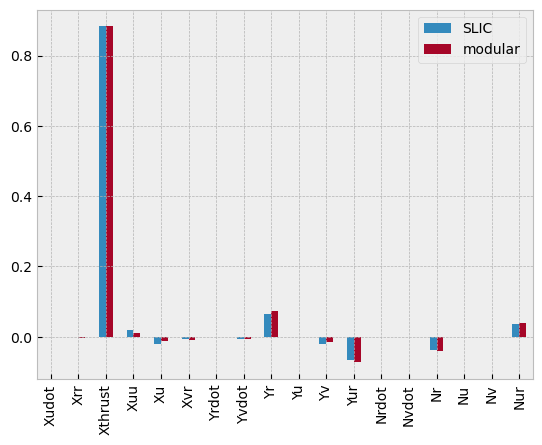

In [446]:
df_parameters.dropna(axis=1).transpose().plot.bar()

In [447]:
new_parameters.update(rudder_parameters)

In [448]:
model2 = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=new_parameters, 
                               control_keys=['delta','thrust'], do_create_jacobian=False)

rudders2 = SemiempiricalRudderSystem(ship=model2, create_jacobians=False)
model2.subsystems['rudders'] = rudders2
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull2 = PrimeEquationSubSystem(ship=model2, equations=equations_hull, create_jacobians=False)
model2.subsystems['hull'] = hull2

In [449]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [450]:
result2 = model2.simulate(data)

In [451]:
result_old_modular = model_old_modular.simulate(data)

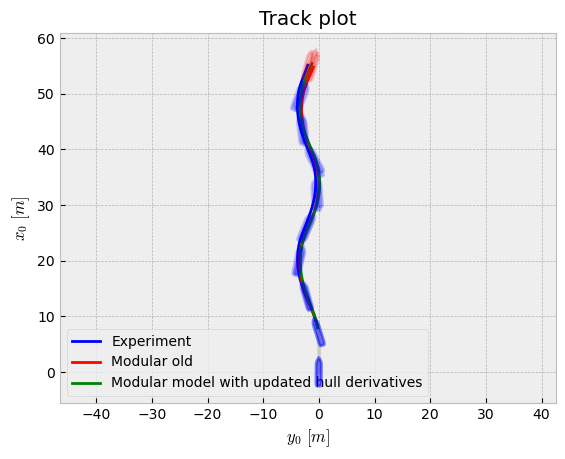

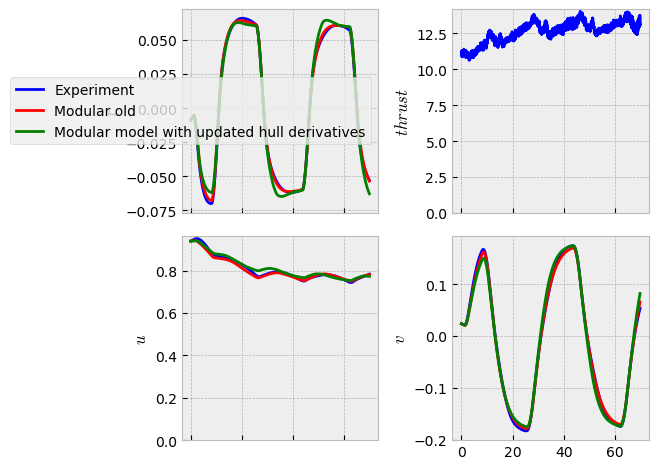

In [452]:
dataframes = {
              'Experiment':data,
              'Modular old':result_old_modular,
              'Modular model with updated hull derivatives':result2,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [453]:
result_old_modular.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,X_R,Y_R,N_R,X_H,Y_H,N_H,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.001498,-0.002389,0.003981,-1.497989e-09,-0.000315,0.000763,0.736567,-5.270261,4.546532,0.736567,-5.270576,4.547296,-0.025223,0.939521
0.01,0.939238,0.023671,-0.008840,0.006527,-0.036697,0.007784,0.001568,-0.002404,0.003964,-5.992147e-09,-0.000630,0.001527,0.766260,-5.267797,4.525079,0.766260,-5.268427,4.526606,-0.025197,0.939536
0.02,0.939256,0.023647,-0.008800,0.015918,-0.036388,0.007696,0.001583,-0.002419,0.003946,-5.992370e-09,-0.000630,0.001527,0.772059,-5.265296,4.503733,0.772059,-5.265927,4.505259,-0.025171,0.939554
0.03,0.939271,0.023623,-0.008761,0.025308,-0.036080,0.007608,0.001511,-0.002434,0.003928,-5.992557e-09,-0.000630,0.001527,0.740747,-5.262729,4.482467,0.740747,-5.263359,4.483994,-0.025145,0.939568
0.04,0.939284,0.023598,-0.008722,0.034699,-0.035772,0.007521,0.001349,-0.002448,0.003910,-5.992714e-09,-0.000630,0.001527,0.670321,-5.260099,4.461287,0.670321,-5.260730,4.462813,-0.025119,0.939581


<Axes: >

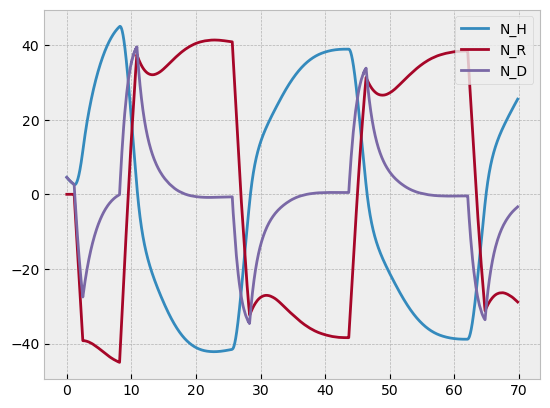

In [454]:
result_old_modular.plot(y=['N_H','N_R','N_D'])

<Axes: >

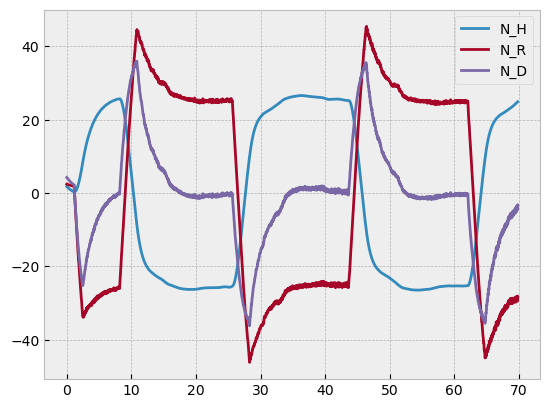

In [455]:
result2.plot(y=['N_H','N_R','N_D'])

<Axes: >

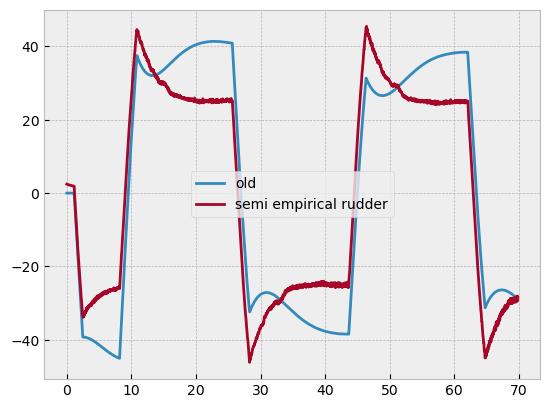

In [456]:
fig,ax=plt.subplots()
result_old_modular.plot(y='N_R', ax=ax, label='old')
result2.plot(y='N_R', ax=ax, label='semi empirical rudder')


<Axes: >

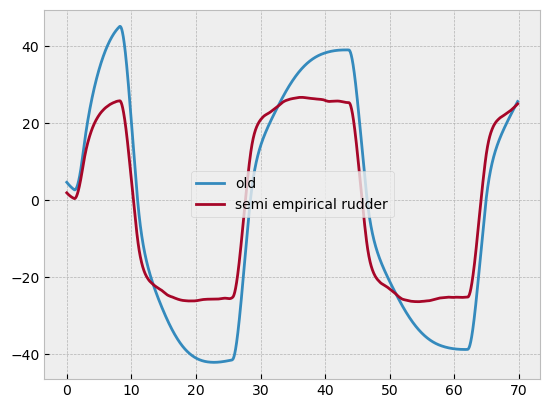

In [470]:
fig,ax=plt.subplots()
result_old_modular.plot(y='N_H', ax=ax, label='old')
result2.plot(y='N_H', ax=ax, label='semi empirical rudder')


In [458]:
data['delta']

0.000000    -0.000007
0.010000    -0.000014
0.020000    -0.000014
0.030000    -0.000014
0.040000    -0.000014
               ...   
69.780004    0.349065
69.790004    0.349078
69.800004    0.349078
69.810004    0.349065
69.820004    0.349078
Name: delta, Length: 6983, dtype: float64

<Axes: >

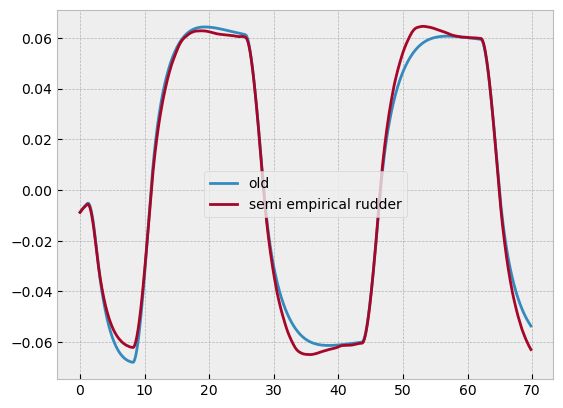

In [459]:
fig,ax=plt.subplots()
result_old_modular.plot(y='r', ax=ax, label='old')
result2.plot(y='r', ax=ax, label='semi empirical rudder')

In [460]:
result2.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.001087,-0.002218,0.003731,1.142184,-0.037539,-0.056316,-1.011362,2.449721,0.616226,-4.141730,1.813006,0.559910,-5.153092,4.262727,-0.025223,0.939521
0.01,0.939234,0.023673,-0.008842,0.006527,-0.036697,0.007784,0.001158,-0.002231,0.003713,1.143278,-0.037423,-0.056359,-1.010156,2.446799,0.646382,-4.139873,1.793904,0.590023,-5.150029,4.240702,-0.025199,0.939532
0.02,0.939246,0.023651,-0.008805,0.015918,-0.036388,0.007696,0.001174,-0.002242,0.003692,1.143510,-0.037322,-0.056331,-1.007845,2.441201,0.652664,-4.137985,1.774925,0.596333,-5.145830,4.216126,-0.025175,0.939544
0.03,0.939257,0.023628,-0.008769,0.025308,-0.036079,0.007608,0.001103,-0.002251,0.003669,1.142395,-0.037266,-0.056203,-1.004363,2.432768,0.621807,-4.136059,1.756106,0.565603,-5.140423,4.188874,-0.025151,0.939554
0.04,0.939266,0.023606,-0.008732,0.034699,-0.035772,0.007521,0.000942,-0.002258,0.003643,1.139859,-0.037257,-0.055970,-0.999654,2.421360,0.551816,-4.134097,1.737443,0.495846,-5.133751,4.158803,-0.025127,0.939563


In [461]:
rudders2.equations.keys()

dict_keys(['V_x', 'C_L', 'X_R', 'Y_R', 'N_R'])

In [462]:
rudders2.equations['V_x']

Eq(V_x, r_0**2*u*(1 - w_f)*(0.02823576*pi**(5/2)*n_prop*r_0**3*rho*u**2*sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))*(1 - w_f)**2 + 0.00941192*pi**3*n_prop*r_0**3*rho*u**2*(1 - w_f)**2 + pi**(3/2)*n_prop*rho*u**2*((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))**(3/2)*(1 - w_f)**2*(19.4030100757589*r_0**3*(x/r_0)**(3/2)*sqrt((sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2)) + sqrt(pi))/sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))) + 0.00941192*r_0**3 + 10000.0*x**3) + pi**2*r_0*(19.4030100757589*(x/r_0)**(3/2)*sqrt((sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2)) + sqrt(pi))/sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))) + 0.02823576)*(pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust))/(sqrt(pi)*(pi*

In [463]:
states_dict = {
'x0':0,
'y0':0,
'psi':0,
'u':data['u'].mean(),
'v':0,
'r':0,
}

control={
'delta':0,
'thrust':data['thrust'].mean(),
}
rudders2.calculate_forces(states_dict=states_dict, control=control, calculation={})

{'V_x': 1.132833216673252,
 'C_L': 0.0,
 'X_R': -0.04652826145010509,
 'Y_R': 0.0,
 'N_R': -0.0}

In [464]:
states_dict

{'x0': 0,
 'y0': 0,
 'psi': 0,
 'u': 0.8075123973077567,
 'v': 0,
 'r': 0,
 'U': 0.8075123973077567}

In [465]:
model2.ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2,
 'x_R': -2.42219908951329,
 'y_R': 0,
 'z_R': 0,
 'A_R': 0.041238571024601746,
 'b_R': 0.17427184466019416,
 'w_f': 0.151,
 'r_0': 0.06067961165048543,
 'x': 0.1}

In [466]:
model2.ship_parameters['b_R'] = 1.0*0.17427184466019416
model2.parameters['C_L_tune']=1
model2.parameters['delta_lim'] = 2*0.6981317007977318

In [467]:
model2.parameters

{'Xudot': 0.00017880704448812042,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Xthrust': 0.883,
 'Xvr': -0.009458061413533156,
 'Xuu': 0.010958159869198585,
 'Xu': -0.011791951901039818,
 'Xrr': -0.004130349344617494,
 'Yr': 0.072168098238084,
 'Yur': -0.07323628044659049,
 'Yu': -2.0743518010719095e-05,
 'Yv': -0.015938493305817904,
 'Nr': -0.04110151306199037,
 'Nur': 0.03913096840267717,
 'Nu': -6.477134602741852e-06,
 'Nv': -0.002177969264925432,
 'C_L_tune': 1,
 'delta_lim': 1.3962634015954636,
 'kappa': 0.5,
 'nu': 1.18849e-06}

In [468]:
df_ = pd.DataFrame()
df_['delta'] = np.deg2rad(np.linspace(-35,35,100))
df_['thrust'] = data['thrust'].mean()
df_['x0']=0
df_['y0']=0
df_['psi']=0
df_['u'] = data['u'].mean()
df_['v']=0
df_['r']=0


calculation2 = rudders2.calculate_forces(states_dict=df_, control=df_[model.control_keys], calculation={})
df2_ = pd.concat((df_,pd.DataFrame(calculation2, index=df_.index)), axis=1)

calculation = rudders_old_modular.calculate_forces(states_dict=df_, control=df_[model.control_keys], calculation={})
df1_ = pd.concat((df_,pd.DataFrame(calculation, index=df_.index)), axis=1)

<Axes: xlabel='delta'>

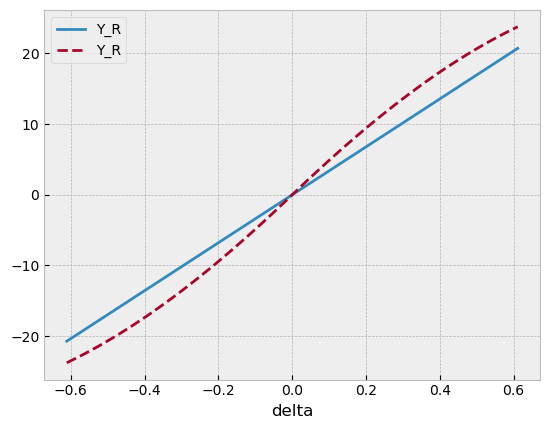

In [469]:
fig,ax=plt.subplots()
df1_.plot(x='delta', y='Y_R', ax=ax)
df2_.plot(x='delta', y='Y_R', style='--',ax=ax)
